# Tuning and Optimizing Neural Networks - Lab

## Introduction

Now that you've seen some regularization, initialization and optimization techniques, its time to synthesize those concepts into a cohesive modeling pipeline.  

With this pipeline, you will not only fit an initial model but will also attempt to set various hyperparameters for regularization techniques. Your final model selection will pertain to the test metrics across these models. This will more naturally simulate a problem you might be faced with in practice, and the various modeling decisions you are apt to encounter along the way.  

Recall that our end objective is to achieve a balance between overfitting and underfitting. You've seen the bias variance trade-off, and the role of regularization in order to reduce overfitting on training data and improving generalization to new cases. Common frameworks for such a procedure include train/validate/test methodology when data is plentiful, and K-folds cross-validation for smaller, more limited datasets. In this lab, you'll perform the latter, as the dataset in question is fairly limited. 

## Objectives

You will be able to:

* Implement a K-folds cross validation modeling pipeline
* Apply normalization as a preprocessing technique
* Apply regularization techniques to improve your model's generalization
* Choose an appropriate optimization strategy 

In [35]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras import initializers
from keras import layers
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from keras import optimizers
from sklearn.model_selection import train_test_split


## Loading the Data

Load and preview the dataset below.

In [36]:
# Your code here; load and preview the dataset
import pandas as pd

data = pd.read_csv("loan_final.csv", header=0)

# drop rows with no label
data.dropna(subset=['total_pymnt'],inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42535 entries, 0 to 42537
Data columns (total 16 columns):
loan_amnt              42535 non-null float64
funded_amnt_inv        42535 non-null float64
term                   42535 non-null object
int_rate               42535 non-null object
installment            42535 non-null float64
grade                  42535 non-null object
emp_length             41423 non-null object
home_ownership         42535 non-null object
annual_inc             42531 non-null float64
verification_status    42535 non-null object
loan_status            42535 non-null object
purpose                42535 non-null object
addr_state             42535 non-null object
total_acc              42506 non-null float64
total_pymnt            42535 non-null float64
application_type       42535 non-null object
dtypes: float64(6), object(10)
memory usage: 5.5+ MB


In [37]:
#df=df.dropna()


## Defining the Problem

Set up the problem by defining X and y. 

For this problem use the following variables for X:
* loan_amnt
* home_ownership
* funded_amnt_inv
* verification_status
* emp_length
* installment
* annual_inc

Our target variable y will be ```total_pymnt```

In [38]:
import numpy as np

features = ['loan_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'home_ownership', 'verification_status', 'emp_length']

X = data.loc[:, features]
y = data.loc[:, 'total_pymnt']

In [39]:
X.shape

(42535, 7)

In [40]:
y.shape

(42535,)

In [41]:
#X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42)


## Generating a Hold Out Test Set

While we will be using K-fold cross validation to select an optimal model, we still want a final hold out test set that is completely independent of any modeling decisions. As such, pull out a sample of 10% of the total available data. For consistency of results, use random seed 123. 

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31901 entries, 41522 to 15725
Data columns (total 7 columns):
loan_amnt              31901 non-null float64
funded_amnt_inv        31901 non-null float64
installment            31901 non-null float64
annual_inc             31897 non-null float64
home_ownership         31901 non-null object
verification_status    31901 non-null object
emp_length             31108 non-null object
dtypes: float64(4), object(3)
memory usage: 1.9+ MB


### Preprocessing Steps
* Fill in missing values with SimpleImputer
* Standardize continuous features with StandardScalar()
* One hot encode categorical features with OneHotEncoder()

In [43]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


# Select continuous features
cont_features = ['loan_amnt', 'funded_amnt_inv', 'installment', 'annual_inc']
X_train_cont = X_train.loc[:, cont_features]

# Fill missing values with the mean
cont_imp = SimpleImputer(strategy='mean')
cont_imp.fit(X_train_cont)
X_train_cont = cont_imp.transform(X_train_cont)

# standardized inputs
sc = StandardScaler()
sc.fit(X_train_cont)
X_train_scaled = sc.transform(X_train_cont)

# Create continuous features dataframe
cont_train_df = pd.DataFrame(X_train_scaled, columns=cont_features)

# Select only the categorical features
cat_features = ['home_ownership', 'verification_status', 'emp_length']
X_train_cat = X_train.loc[:, cat_features]

# Replace NaNs with 'missing'
cat_imp = SimpleImputer(strategy='constant', fill_value='missing')
cat_imp.fit(X_train_cat)
X_train_cat = cat_imp.transform(X_train_cat)

# Encode Categorical Features
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train_cat)
X_train_ohe = ohe.transform(X_train_cat)

# Create categorical features dataframe
cat_train_df = pd.DataFrame(X_train_ohe.todense(), columns=ohe.get_feature_names(input_features=cat_features))

# Combine continuous and categorical feature dataframes
X_train_all = pd.concat([cont_train_df, cat_train_df], axis=1)

X_train_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31901 entries, 0 to 31900
Data columns (total 24 columns):
loan_amnt                              31901 non-null float64
funded_amnt_inv                        31901 non-null float64
installment                            31901 non-null float64
annual_inc                             31901 non-null float64
home_ownership_MORTGAGE                31901 non-null float64
home_ownership_NONE                    31901 non-null float64
home_ownership_OTHER                   31901 non-null float64
home_ownership_OWN                     31901 non-null float64
home_ownership_RENT                    31901 non-null float64
verification_status_Not Verified       31901 non-null float64
verification_status_Source Verified    31901 non-null float64
verification_status_Verified           31901 non-null float64
emp_length_1 year                      31901 non-null float64
emp_length_10+ years                   31901 non-null float64
emp_length_2 years     

### Preprocess Your Holdout Set

Make sure to use your StandardScalar and OneHotEncoder that you already fit on the training set to transform your test set

In [44]:
# Select continuous features
X_test_cont = X_test.loc[:, cont_features]

# Fill missing values with the mean
X_test_cont = cont_imp.transform(X_test_cont)

# standardized inputs
X_test_scaled = sc.transform(X_test_cont)

# Create continuous features dataframe
cont_test_df = pd.DataFrame(X_test_scaled, columns=cont_features)

# Select only the categorical features
X_test_cat = X_test.loc[:, cat_features]

# Replace NaNs with 'missing'
X_test_cat = cat_imp.transform(X_test_cat)

# Encode Categorical Features
X_test_ohe = ohe.transform(X_test_cat)

# Create categorical features dataframe
cat_test_df = pd.DataFrame(X_test_ohe.todense(), columns=ohe.get_feature_names(input_features=cat_features))

# Combine continuous and categorical feature dataframes
X_test_all = pd.concat([cont_test_df, cat_test_df], axis=1)

X_test_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10634 entries, 0 to 10633
Data columns (total 24 columns):
loan_amnt                              10634 non-null float64
funded_amnt_inv                        10634 non-null float64
installment                            10634 non-null float64
annual_inc                             10634 non-null float64
home_ownership_MORTGAGE                10634 non-null float64
home_ownership_NONE                    10634 non-null float64
home_ownership_OTHER                   10634 non-null float64
home_ownership_OWN                     10634 non-null float64
home_ownership_RENT                    10634 non-null float64
verification_status_Not Verified       10634 non-null float64
verification_status_Source Verified    10634 non-null float64
verification_status_Verified           10634 non-null float64
emp_length_1 year                      10634 non-null float64
emp_length_10+ years                   10634 non-null float64
emp_length_2 years     

In [45]:
y_train

41522     6987.426375
30479    15792.935150
4534       280.910000
33113     9624.197218
40008     6632.509096
             ...     
7763     30091.240000
15377    11078.043150
17730     1205.720000
28030     8024.326389
15725     3706.919962
Name: total_pymnt, Length: 31901, dtype: float64

## Defining a K-fold Cross Validation Methodology

Now that your have a complete holdout test set, write a function that takes in the remaining data and performs k-folds cross validation given a model object. 

> Note: Think about how you will analyze the output of your models in order to select an optimal model. This may involve graphs, although alternative approaches are certainly feasible.

In [46]:
# Your code here; define a function to evaluate a model object using K folds cross validation.
# Your code here; define a function to evaluate a model object using K folds cross validation.
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=100):
    colors = sns.color_palette("Set2")

    validation_scores = []
    
    kf = KFold(n_splits=10, shuffle=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(12,8))
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        "Currently graph imaging assumes 10 folds and is hardcoded to 5x2 layout."
        
        row = i//5
        col = i%5
        
        X_train, X_val = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train, y_val = labels_train.iloc[train_index], labels_train.iloc[test_index]
        
        model = model_obj
        
        hist = model.fit(X_train, y_train, batch_size=32,
                         epochs=n_epochs, verbose=0, validation_data = (X_val, y_val))
        #Note: verboxe=0 turns off printouts regarding training for each epoch.
        #Potential simpler methodology
        validation_score = model.evaluate(X_val, y_val)
        validation_scores.append(validation_score)
        ax = axes[row, col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[0])

        k = 'loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[1])
        ax.set_title('Fold {} Validation'.format(i+1))
        
    #Final Graph Formatting
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.legend(bbox_to_anchor=(1,1))
    
    #General Overview
    validation_score = np.average(validation_scores)
    print('Mean Validation Score:', validation_score)
    print('Standard Deviation of Validation Scores:', np.std(validation_scores))
    return validation_score

## Building a Baseline Model

Here, it is also important to define your evaluation metric that you will look to optimize while tuning the model. Additionally, model training to optimize this metric may consist of using a validation and test set if data is plentiful, or k-folds cross-validation if data is limited. Since this dataset is not overly large, it will be most appropriate to set up a k-folds cross-validation  

In [47]:
from keras.models import Sequential
from keras.layers import Dense

input_dim = X_train_all.shape[1]

np.random.seed(123)
model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

## Evaluating the Baseline Model with K-Folds Cross Validation

Use your k-folds function to evaluate the baseline model.  

Note: This code block is likely to take 10-20 minutes to run depending on the specs on your computer.
Because of time dependencies, it can be interesting to begin timing these operations for future reference.

Here's a simple little recipe to achieve this:
```
import time
import datetime

now = datetime.datetime.now()
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
```

3190/3190 [==============================] - 0s 15us/step
Mean Validation Score: 83307813.97071454
Standard Deviation of Validation Scores: 1972843.124214167
Time Elapsed: 0:18:32.754178


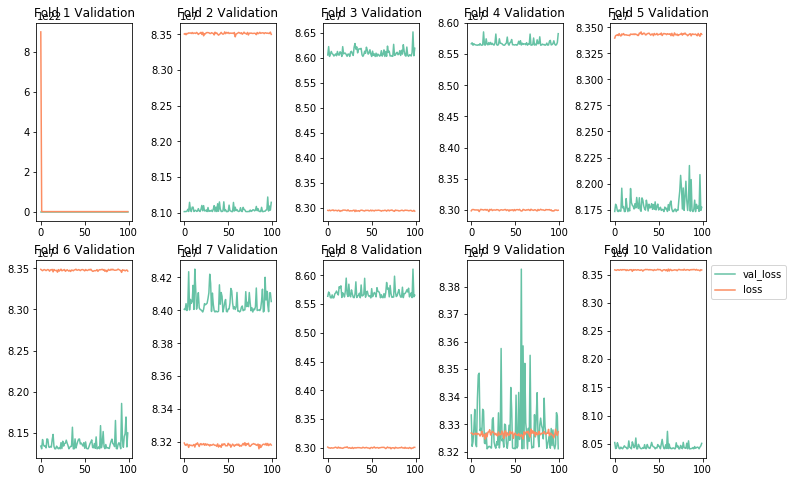

In [48]:
import time
import datetime

now = datetime.datetime.now()

k_folds(X_train_all, y_train, model)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

## Intentionally Overfitting a Model

Now that you've developed a baseline model, its time to intentionally overfit a model. To overfit a model, you can:
* Add layers
* Make the layers bigger
* Increase the number of training epochs

Again, be careful here. Think about the limitations of your resources, both in terms of your computers specs and how much time and patience you have to let the process run. Also keep in mind that you will then be regularizing these overfit models, meaning another round of experiments and more time and resources.

3190/3190 [==============================] - 0s 22us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 0:25:59.366744


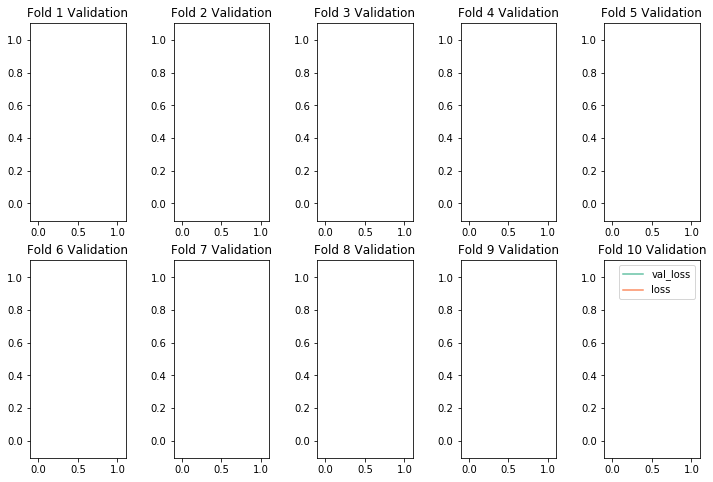

In [49]:
# Your code here
# Timing Notes: On a top of the line mac-book pro, using our 10 fold cross validation methodology,
# a 5-layer neural network with 10 units per hidden layer and 100 epochs took ~15 minutes to train and validate

now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

#Model Mod 1: Adding More Layers
model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train_all, y_train, model)    

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)



ValueError: Error when checking input: expected dense_10_input to have shape (24,) but got array with shape (7,)

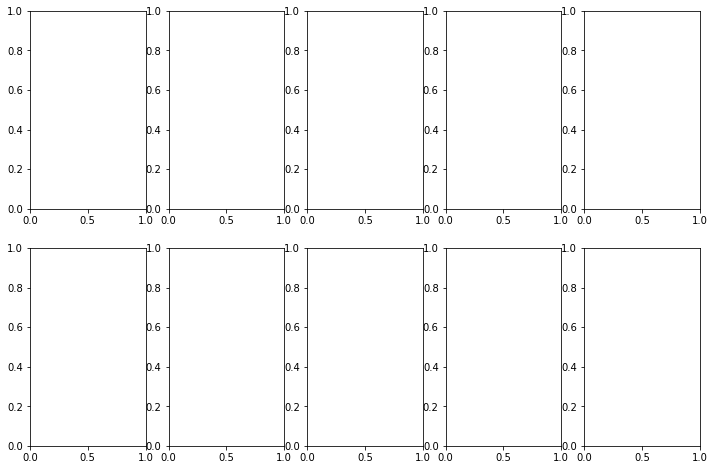

In [50]:
now = datetime.datetime.now()
k_folds(X_train, y_train, model, k=10)
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

In [ ]:
# Your code here; try some methods to overfit your network
# ⏰ This cell may take several mintes to run

In [ ]:
# Your code here; try some methods to overfit your network
# ⏰ This cell may take several mintes to run

## Regularizing the Model to Achieve Balance  

Now that you have a powerful model (albeit an overfit one), we can now increase the generalization of the model by using some of the regularization techniques we discussed. Some options you have to try include:  
* Adding dropout
* Adding L1/L2 regularization
* Altering the layer architecture (add or remove layers similar to above)  

This process will be constrained by time and resources. Be sure to test at least 2 different methodologies, such as dropout and L2 regularization. If you have the time, feel free to continue experimenting.

Notes: 

In [ ]:
# L1 Regularization
from keras import regularizers

#kernel_regularizer=regularizers.l1(0.005)
#kernel_regularizer=regularizers.l2(0.005)
#model.add(layers.Dropout(0.3))

now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train_all, y_train, model, n_epochs=250) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

In [ ]:
# Your code here; try some regularization or other methods to tune your network
# ⏰ This cell may take several mintes to run
# Model Mod 3: More Layers, More Epochs 
# Timing Notes: On a top of the line mac-book pro, using our 10 fold cross validation methodology,
# a 5-layer neural network with 10 units per hidden layer and 250 epochs took ~45 minutes to train and validate
# L2 Regularization and Early Stopping
now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train_all, y_train, model, n_epochs=75) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

In [ ]:
# Your code here; try some regularization or other methods to tune your network
# ⏰ This cell may take several mintes to run
# Dropout and Early Stopping
from keras import layers

now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train_all, y_train, model, n_epochs=75) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

In [ ]:
# Your code here; try some regularization or other methods to tune your network
# ⏰ This cell may take several mintes to run
# L1, Dropout and Early Stopping

now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train_all, y_train, model, n_epochs=75) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
end = datetime.datetime.now()
elapsed = end - start
print('Total Time Elapsed:', elapsed)

## Final Evaluation

Now that you have selected a network architecture, tested various regularization procedures and tuned hyperparameters via a validation methodology, it is time to evaluate your finalized model once and for all. Fit the model using all of the training and validation data using the architecture and hyperparameters that were most effective in your experiments above. Afterwards, measure the overall performance on the hold-out test data which has been left untouched (and hasn't leaked any data into the modeling process)!

In [ ]:
# Your code here; final model training on entire training set followed by evaluation on hold-out data
# ⏰ This cell may take several mintes to run

# Your code here; final model training on entire training set followed by evaluation on hold-out data

# Based on our model runs above, it appears that using  L2 Regularization and Early Stopping
# improves our variance 10 fold in exchange for a slight increase in MSE
# As such, we will choose this as our final model in hopes that the model will have improved generalization
now = datetime.datetime.now()

input_dim = X_train_all.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

hist =  hist = model.fit(X_train_all, y_train, batch_size=32, epochs=75)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
model.evaluate(X_test_all, y_test)


## Summary

In this lab, you investigated some data from *The Lending Club* in a complete data science pipeline regarding neural networks. You began with reserving a hold-out set for testing which never was touched during the modeling phase. From there, you implemented a k-fold cross validation methodology in order to assess an initial baseline model and various regularization methods. From here, you'll begin to investigate other neural network architectures such as CNNs.